<a href="https://colab.research.google.com/github/kplam3003/Phuoc-Lam/blob/main/transferred%20model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import zipfile
import urllib.request
import os.path as osp
import glob
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import json
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models, transforms
from tqdm import tqdm

In [ ]:
url = 'http://download.pytorch.org/tutorial/hymenoptera_data.zip'
save_path = os.path.join("/content/sample_data", 'hymenoptera_data.zip')
if not os.path.exists(save_path):
  urllib.request.urlretrieve(url,save_path)
  zip = zipfile.ZipFile(save_path)
  zip.extractall("/content/sample_data")
  zip.close()
  os.remove(save_path )

In [ ]:
!ls /content/sample_data/hymenoptera_data/train/bees | wc -l

121


In [ ]:
torch.manual_seed(1234)
np.random.seed(123)
random.seed(1234)

In [ ]:
class ImageTransform():
  def __init__(self,resize,mean,std):
    self.data_transform = {'train': transforms.Compose([
        transforms.RandomResizedCrop(resize, scale=(0.5,1)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean,std)]),
        'val': transforms.Compose([
              transforms.Resize(resize),
              transforms.CenterCrop(resize),
              transforms.ToTensor(),
              transforms.Normalize(mean,std)])}
  def __call__(self,img,phase = 'train'):
    return self.data_transform[phase](img) 

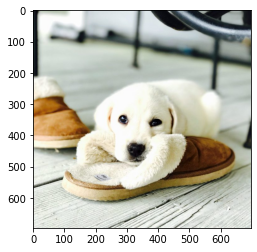

In [ ]:
img_file_path = '/content/sample_data/dog.jpg'
img = Image.open(img_file_path)
plt.imshow(img)
plt.show()

In [ ]:
resize = 224
mean = (0.485, 0.456, 0.406)
std = (0.229,0.224,0.225)
transform = ImageTransform(resize,mean,std)
img_transformed = transform(img, phase = 'train')

In [ ]:
img_transformed = img_transformed.numpy().transpose(1,2,0)
img_transformed = np.clip(img_transformed, 0 ,1)
img_transformed.shape

(224, 224, 3)

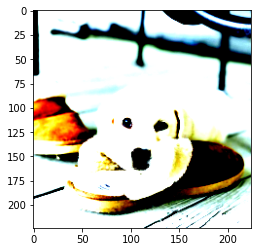

In [ ]:
plt.imshow(img_transformed)
plt.show()

In [ ]:
def make_datapath_list(phase = 'train'):
  rootpath = '/content/sample_data/hymenoptera_data/'
  target_path = osp.join(rootpath+phase+"/**/*.jpg")
  path_list = []
  for path in glob.glob(target_path):
    path_list.append(path)
  return path_list

In [ ]:
path_list = make_datapath_list('train')
path_list

['/content/sample_data/hymenoptera_data/train/bees/2037437624_2d7bce461f.jpg',
 '/content/sample_data/hymenoptera_data/train/bees/478701318_bbd5e557b8.jpg',
 '/content/sample_data/hymenoptera_data/train/bees/2477324698_3d4b1b1cab.jpg',
 '/content/sample_data/hymenoptera_data/train/bees/2495722465_879acf9d85.jpg',
 '/content/sample_data/hymenoptera_data/train/bees/2601176055_8464e6aa71.jpg',
 '/content/sample_data/hymenoptera_data/train/bees/95238259_98470c5b10.jpg',
 '/content/sample_data/hymenoptera_data/train/bees/509247772_2db2d01374.jpg',
 '/content/sample_data/hymenoptera_data/train/bees/3090975720_71f12e6de4.jpg',
 '/content/sample_data/hymenoptera_data/train/bees/2861002136_52c7c6f708.jpg',
 '/content/sample_data/hymenoptera_data/train/bees/3030772428_8578335616.jpg',
 '/content/sample_data/hymenoptera_data/train/bees/2634617358_f32fd16bea.jpg',
 '/content/sample_data/hymenoptera_data/train/bees/2625499656_e3415e374d.jpg',
 '/content/sample_data/hymenoptera_data/train/bees/27653

In [ ]:
len(path_list)

243

In [ ]:
path_list[:10]

['/content/sample_data/hymenoptera_data/train/bees/2037437624_2d7bce461f.jpg',
 '/content/sample_data/hymenoptera_data/train/bees/478701318_bbd5e557b8.jpg',
 '/content/sample_data/hymenoptera_data/train/bees/2477324698_3d4b1b1cab.jpg',
 '/content/sample_data/hymenoptera_data/train/bees/2495722465_879acf9d85.jpg',
 '/content/sample_data/hymenoptera_data/train/bees/2601176055_8464e6aa71.jpg',
 '/content/sample_data/hymenoptera_data/train/bees/95238259_98470c5b10.jpg',
 '/content/sample_data/hymenoptera_data/train/bees/509247772_2db2d01374.jpg',
 '/content/sample_data/hymenoptera_data/train/bees/3090975720_71f12e6de4.jpg',
 '/content/sample_data/hymenoptera_data/train/bees/2861002136_52c7c6f708.jpg',
 '/content/sample_data/hymenoptera_data/train/bees/3030772428_8578335616.jpg']

In [ ]:
train_list = make_datapath_list('train')
val_list = make_datapath_list('val')
train_list

In [ ]:
class MyDataset(data.Dataset):
    def __init__(self, file_list, transform=None, phase="train"):
        self.file_list = file_list
        self.transform = transform
        self.phase = phase
        
    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        
        img_transformed = self.transform(img, self.phase)
        
        if self.phase == "train":
            label = img_path[44:48]
        elif self.phase == "val":
            label = img_path[42:46]
        
        if label == "ants":
            label = 0
        elif label == "bees":
            label = 1
        
        return img_transformed, label


In [ ]:
train_dataset = MyDataset(train_list, transform = ImageTransform(resize,mean,std), phase ='train')
val_dataset = MyDataset(val_list, transform = ImageTransform(resize,mean,std), phase ='val')
 

In [ ]:
index = 0
img,label = train_dataset.__getitem__(50)


In [ ]:
img.shape
print(label)

1


In [ ]:
batch_size = 4
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle = True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size, shuffle = False)

dataloader_dict = {"train":train_dataloader,'val':val_dataloader}


In [ ]:
batch_iterator = iter(dataloader_dict['train'])
inputs, labels = next(batch_iterator)
print(labels)

tensor([0, 1, 0, 1])


# Network


In [ ]:
use_pretrained = True
net = models.vgg16(pretrained = use_pretrained)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:
net.classifier[6] = nn.Linear(in_features = 4096, out_features=2)

In [ ]:
print(net)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
net = net.train()

# Loss

In [ ]:
criterior = nn.CrossEntropyLoss()

**optimizer**

In [ ]:
params_to_update = []
update_params_name = ['classifier.6.weight','classifier.6.bias']
for name,param in net.named_parameters():
  if name in update_params_name:
    param.requires_grad = True
    params_to_update.append(param)
    print(name)
  else:
    param.requires_grad = False
print(params_to_update)

classifier.6.weight
classifier.6.bias
[Parameter containing:
tensor([[ 0.0123, -0.0149,  0.0108,  ..., -0.0105,  0.0127, -0.0115],
        [ 0.0080,  0.0114, -0.0050,  ..., -0.0027, -0.0091,  0.0044]],
       requires_grad=True), Parameter containing:
tensor([0.0013, 0.0018], requires_grad=True)]


In [ ]:
optimizer = optim.SGD(params = net.parameters(), lr= 0.001, momentum=0.9)

In [ ]:
def train_model(net, dataloader_dict, criterior, optimizer, num_epochs):
  for epoch in range(num_epochs):
    print("Epoch {}/{}".format(epoch,num_epochs))
    for phase in ['train','val']:
      if phase =='train':
        net.train()
      else:
        net.eval()
      epoch_loss = 0.0
      epoch_corrects = 0
      if (epoch == 0) and (phase =='train'):
        continue
      for inputs, labels in tqdm(dataloader_dict[phase]):
        optimizer.zero_grad()
        with torch.set_grad_enabled(phase =='train'):
          outputs = net(inputs)
          loss = criterior(outputs, labels)
          _, preds = torch.max(outputs, 1)
          if phase =='train':
            loss.backward()
            optimizer.step()
          epoch_loss += loss.item()*inputs.size(0)
          epoch_corrects += torch.sum(preds ==labels.data)
      epoch_loss = epoch_loss/ len(dataloader_dict[phase].dataset)
      epoch_accuracy = epoch_corrects.double()/ len(dataloader_dict[phase].dataset)
      print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_accuracy))



In [ ]:
num_epochs = 2
train_model(net, dataloader_dict, criterior,optimizer,num_epochs)

Epoch 0/2


100%|██████████| 39/39 [01:17<00:00,  1.98s/it]


val Loss: 0.8763 Acc: 0.2941
Epoch 1/2


100%|██████████| 61/61 [02:01<00:00,  2.00s/it]


train Loss: 0.2397 Acc: 0.8971


100%|██████████| 39/39 [01:17<00:00,  1.97s/it]

val Loss: 0.0970 Acc: 0.9608


In [ ]:
img_file_path = '/content/sample_data/isolated-bee-11548527658wk638hake3.png'
transform = ImageTransform(resize,mean,std)
test_image = Image.open(img_file_path).convert('RGB')
img_transformed = transform(test_image)
img_transformed.shape


torch.Size([3, 224, 224])

In [ ]:
#img_transformed = img_transformed.numpy().transpose(1,2,0)
img_transformed = np.clip(img_transformed, 0 ,1)
img_transformed.shape

torch.Size([3, 224, 224])

TypeError: ignored

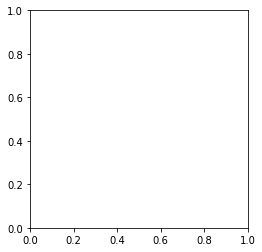

In [ ]:
plt.imshow(img_transformed)
plt.show()

In [ ]:
img_transformed = img_transformed.unsqueeze_(1)
img_transformed.shape

torch.Size([3, 1, 224, 224])

In [ ]:
out = net(img_transformed)
result = predictor.predict_max(out)
print(result)

RuntimeError: ignored